# GCC's ssc-cdi : Tomography Interface for Cateretê, v1.0.0
 
- #### Run first cell to connect to server and install requirements. Run second cell to deploy interface.
- #### To visualize outputs in real time, open the log console at: View > Show Log Console
- #### Questions? E-mail gcc@lnls.br
- #### Installation and User guide [available here](https://10.10.10.141/ssc/wiki/). 
- #### About sscPimega:
    - Measurements done up to July 1st, 2022: use version sscPimega = '0.0.4'
    - Measurements made between July 2nd and October 23rd, 2022: use version sscPimega = '0.0.6'
    - Measurements made from October 24th, 2022: use version sscPimega = '0.1.1'

In [1]:
%matplotlib widget
import sscInstall
# server = sscInstall.connect_server()
# sscInstall.install_jupyter(server,beamline='caterete',sscCdi='0.3.1',sscPtycho='1.0.2',sscPimega='0.1.1',sscRaft='1.0.3',sscRadon='1.0.0',sscResolution='1.2.3')
from sscCdi import jupyter, tomo_jupyter
header,tabs, input_variables_dict = tomo_jupyter.deploy_tabs(0)
display(header,tabs)

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pad_sinogram_frames(padding,path):
    sinogram = np.load(path)
    print("Old shape: ",sinogram.shape)
    sinogram = np.pad(sinogram,((0,0),(padding,padding),(padding,padding)))
    print("New shape: ",sinogram.shape)
    # np.save(path,sinogram)
    return sinogram

path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram.npy"
data = pad_sinogram_frames(100,path)

def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram.npy"
# data = np.load(path)

sigma = 1.5

x = np.linspace(-5, 5,data.shape[2])
y = np.linspace(-5, 5,data.shape[1])
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
border_attenuation_matrix = gaus2d(x, y,sx=sigma,sy=sigma)
for i in range(data.shape[0]):
    if i%50==0: print(i,data.shape[0])
    data[i] = border_attenuation_matrix*data[i]

# path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram_filtered.npy"
np.save(path,data)
print("Done")

In [ ]:
path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_svwt_candb_mem2_01_reconstruction3D_EEM.npy"
path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_wiggle_sinogram.npy"

data = np.load(path)

data.shape
import numpy as np
path = "/ibira/lnls/beamlines/caterete/proposals/20210127/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram.npy"
data = np.load(path)[0:50]

In [ ]:
import numpy
def get_extrapolated_sinogram(sino, pad, L, R):
    if pad==0:
        return sino
    else:
        nrays = sino.shape[0]
        nangles = sino.shape[1]
        n = nrays + 2*pad
        s = numpy.vstack((numpy.zeros([pad,nangles]),sino,numpy.zeros([pad,nangles])) )
        t = numpy.linspace(-1,1,n)
        left = (1.0*(( t < t[pad] ) )) 
        right =  1.0 * (t > t[nrays+pad-1])
        L_ = 1
        R_ = 1
        p = numpy.array( [ s[:,j] + L_*s[pad,j]*numpy.exp(L*(t-t[pad]))*left + R_*s[nrays+pad-1,j]*right*numpy.exp(-R*(t-t[nrays+pad-1])) for j in range(nangles)] ).T
        return p
    
size_rays = data.shape[1]*data.shape[2]
n_angles = data.shape[0]

print(data.shape[1],data.shape[2])

sino = np.zeros((size_rays,n_angles))
    
for i in range(data.shape[0]):
    if i+1%10==0: print(i)
    sino[:,i] = data[i,:,:].flatten()

L    = 10
R    = 10
pad  = 150
sino_ext = get_extrapolated_sinogram( sino, pad, L, R)

print(sino.shape,sino_ext.shape,sino.shape[0]-sino_ext.shape[0])

print(sino_ext.shape[0]/(data.shape[1]-pad))

new_shape = (int(sino_ext.shape[0]/(data.shape[1]-pad)),int(sino_ext.shape[0]/(data.shape[2]-pad)),sino_ext.shape[1])
print("New shape", new_shape)
sino_reshaped = np.reshape(sino_ext, new_shape)

print(sino_reshaped.shape)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2)
# ax1,ax2 = ax.ravel()
# ax1.imshow(sino)
# ax2.imshow(sino_ext)

431
471
1


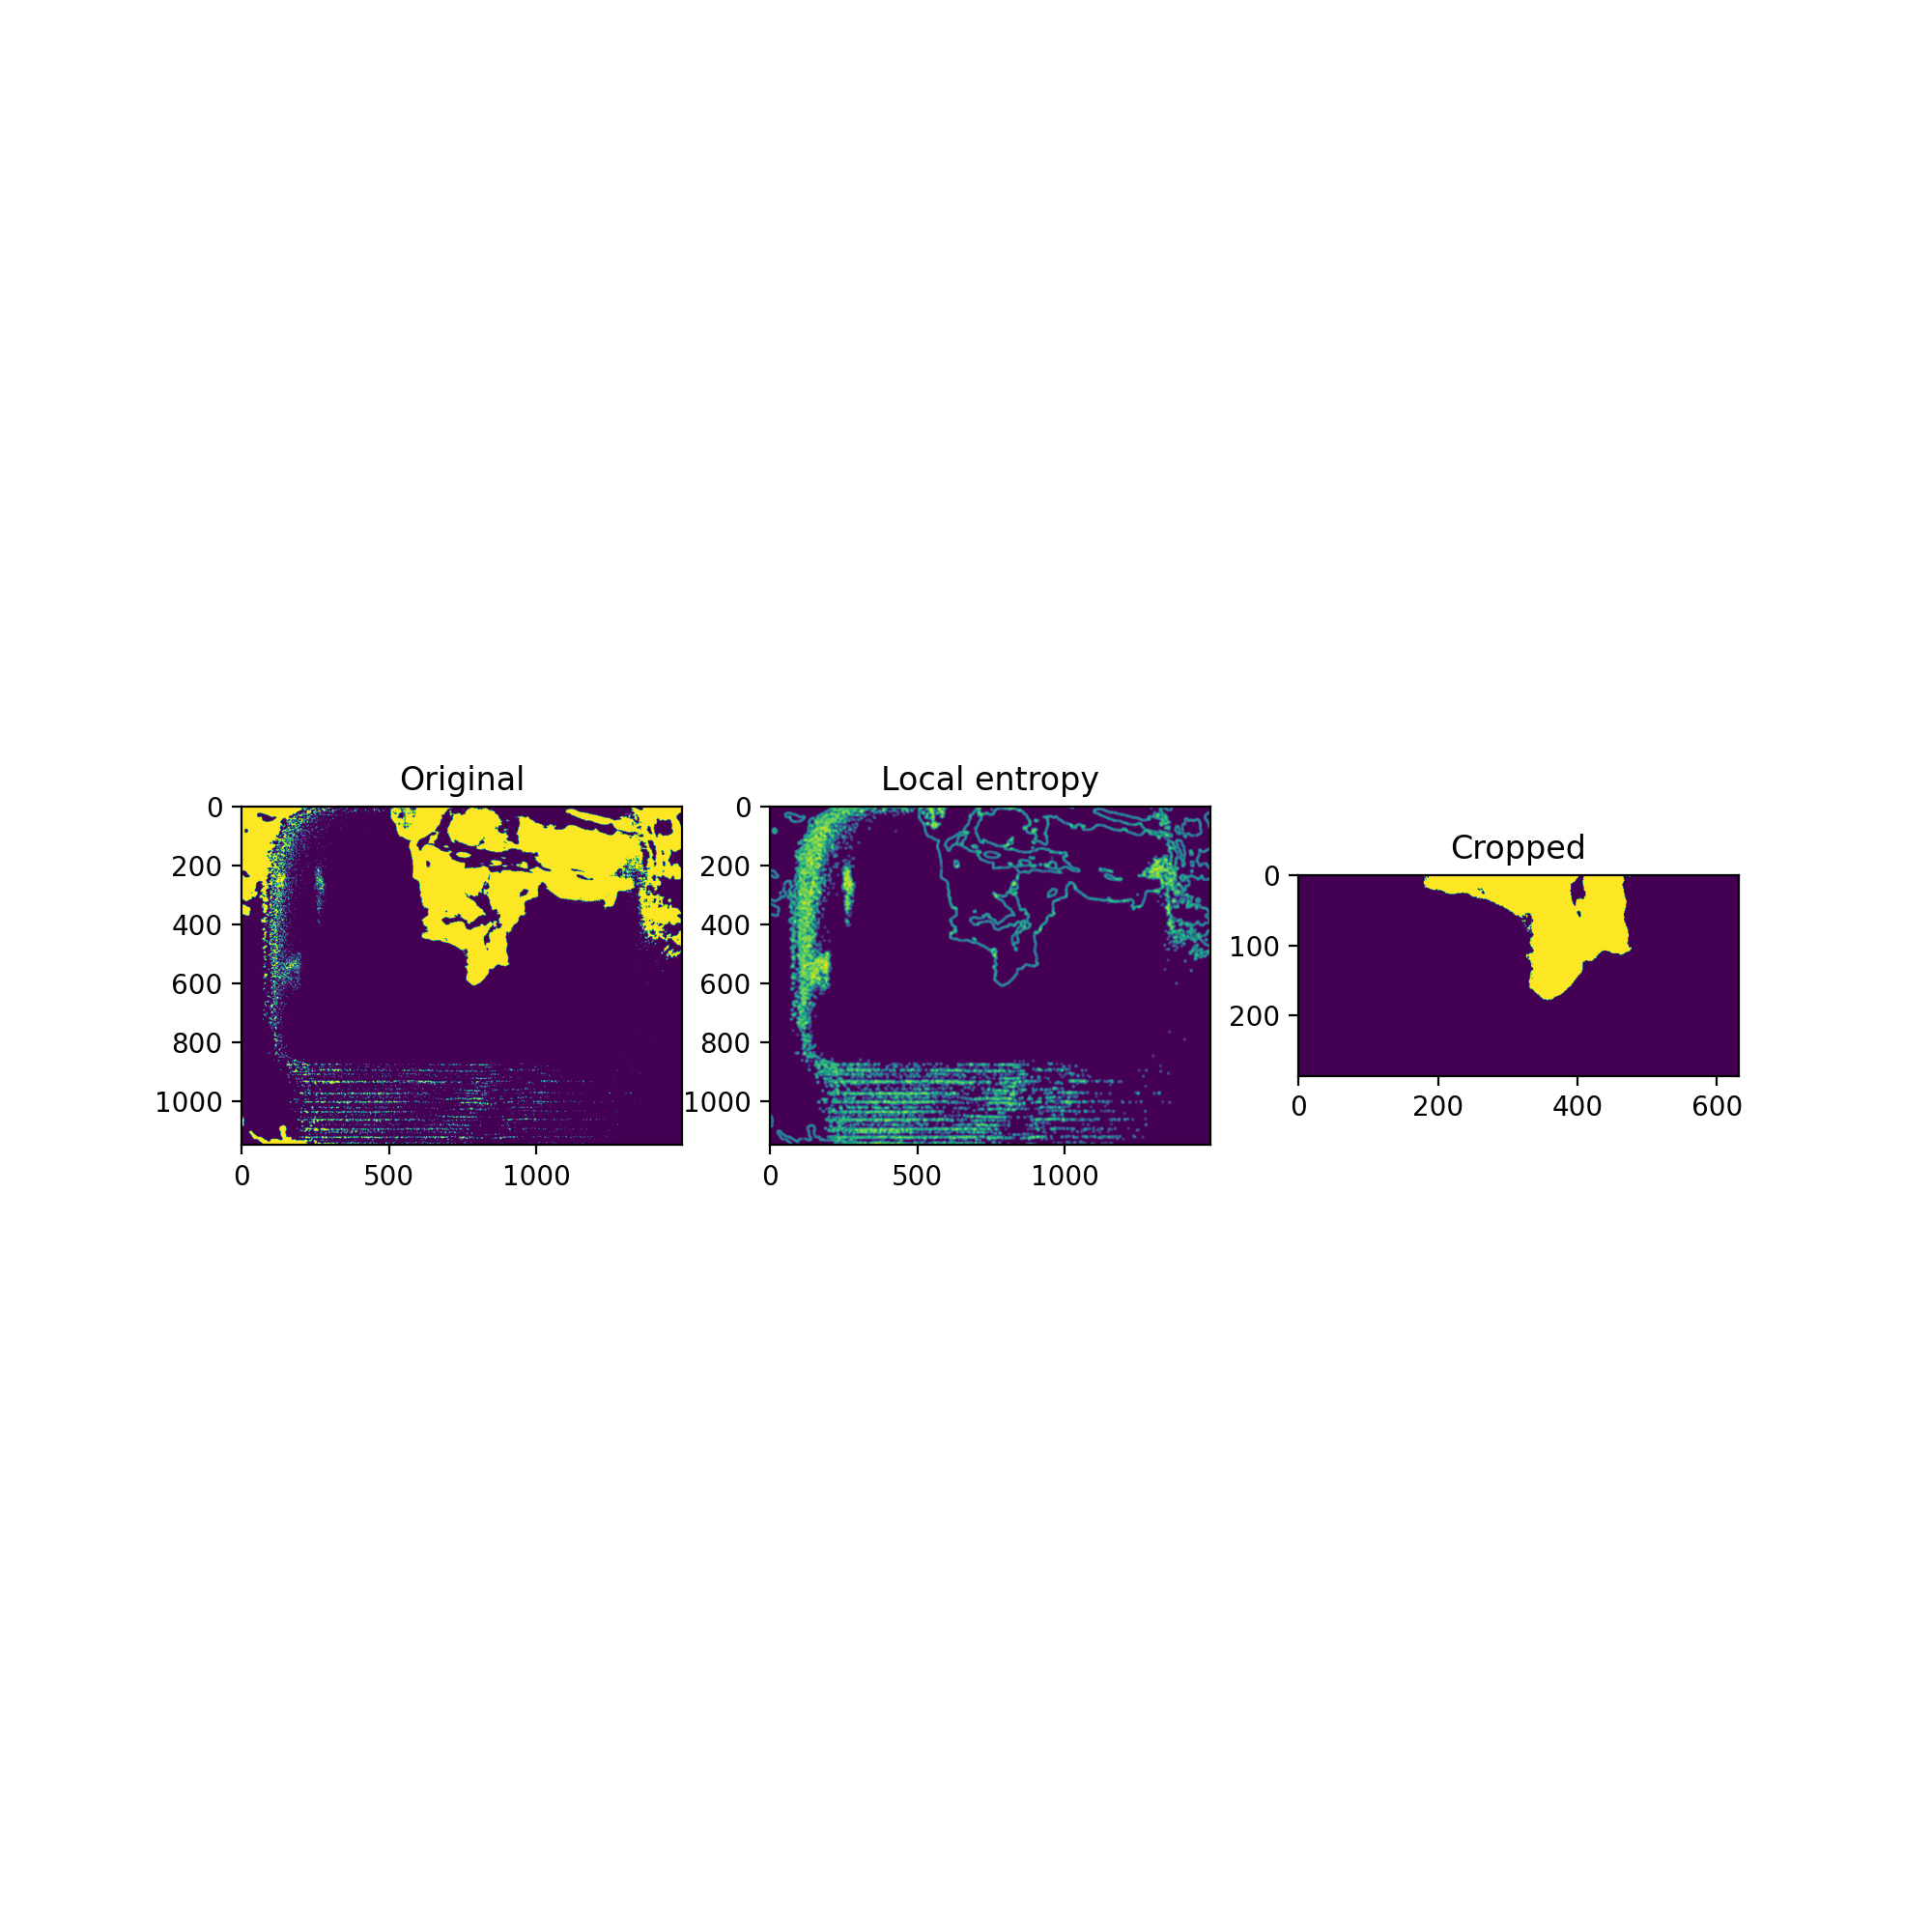

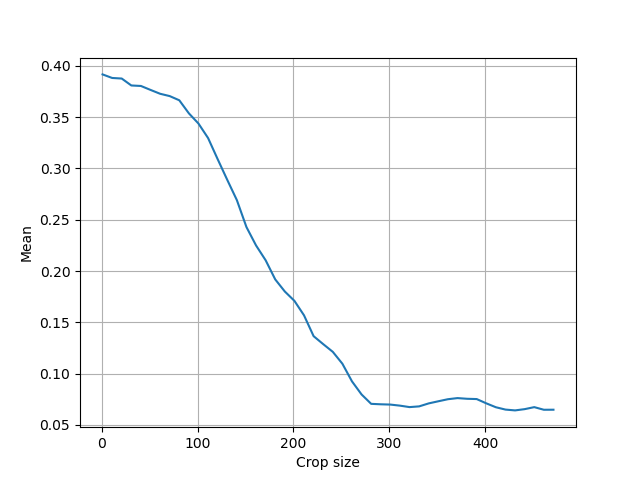

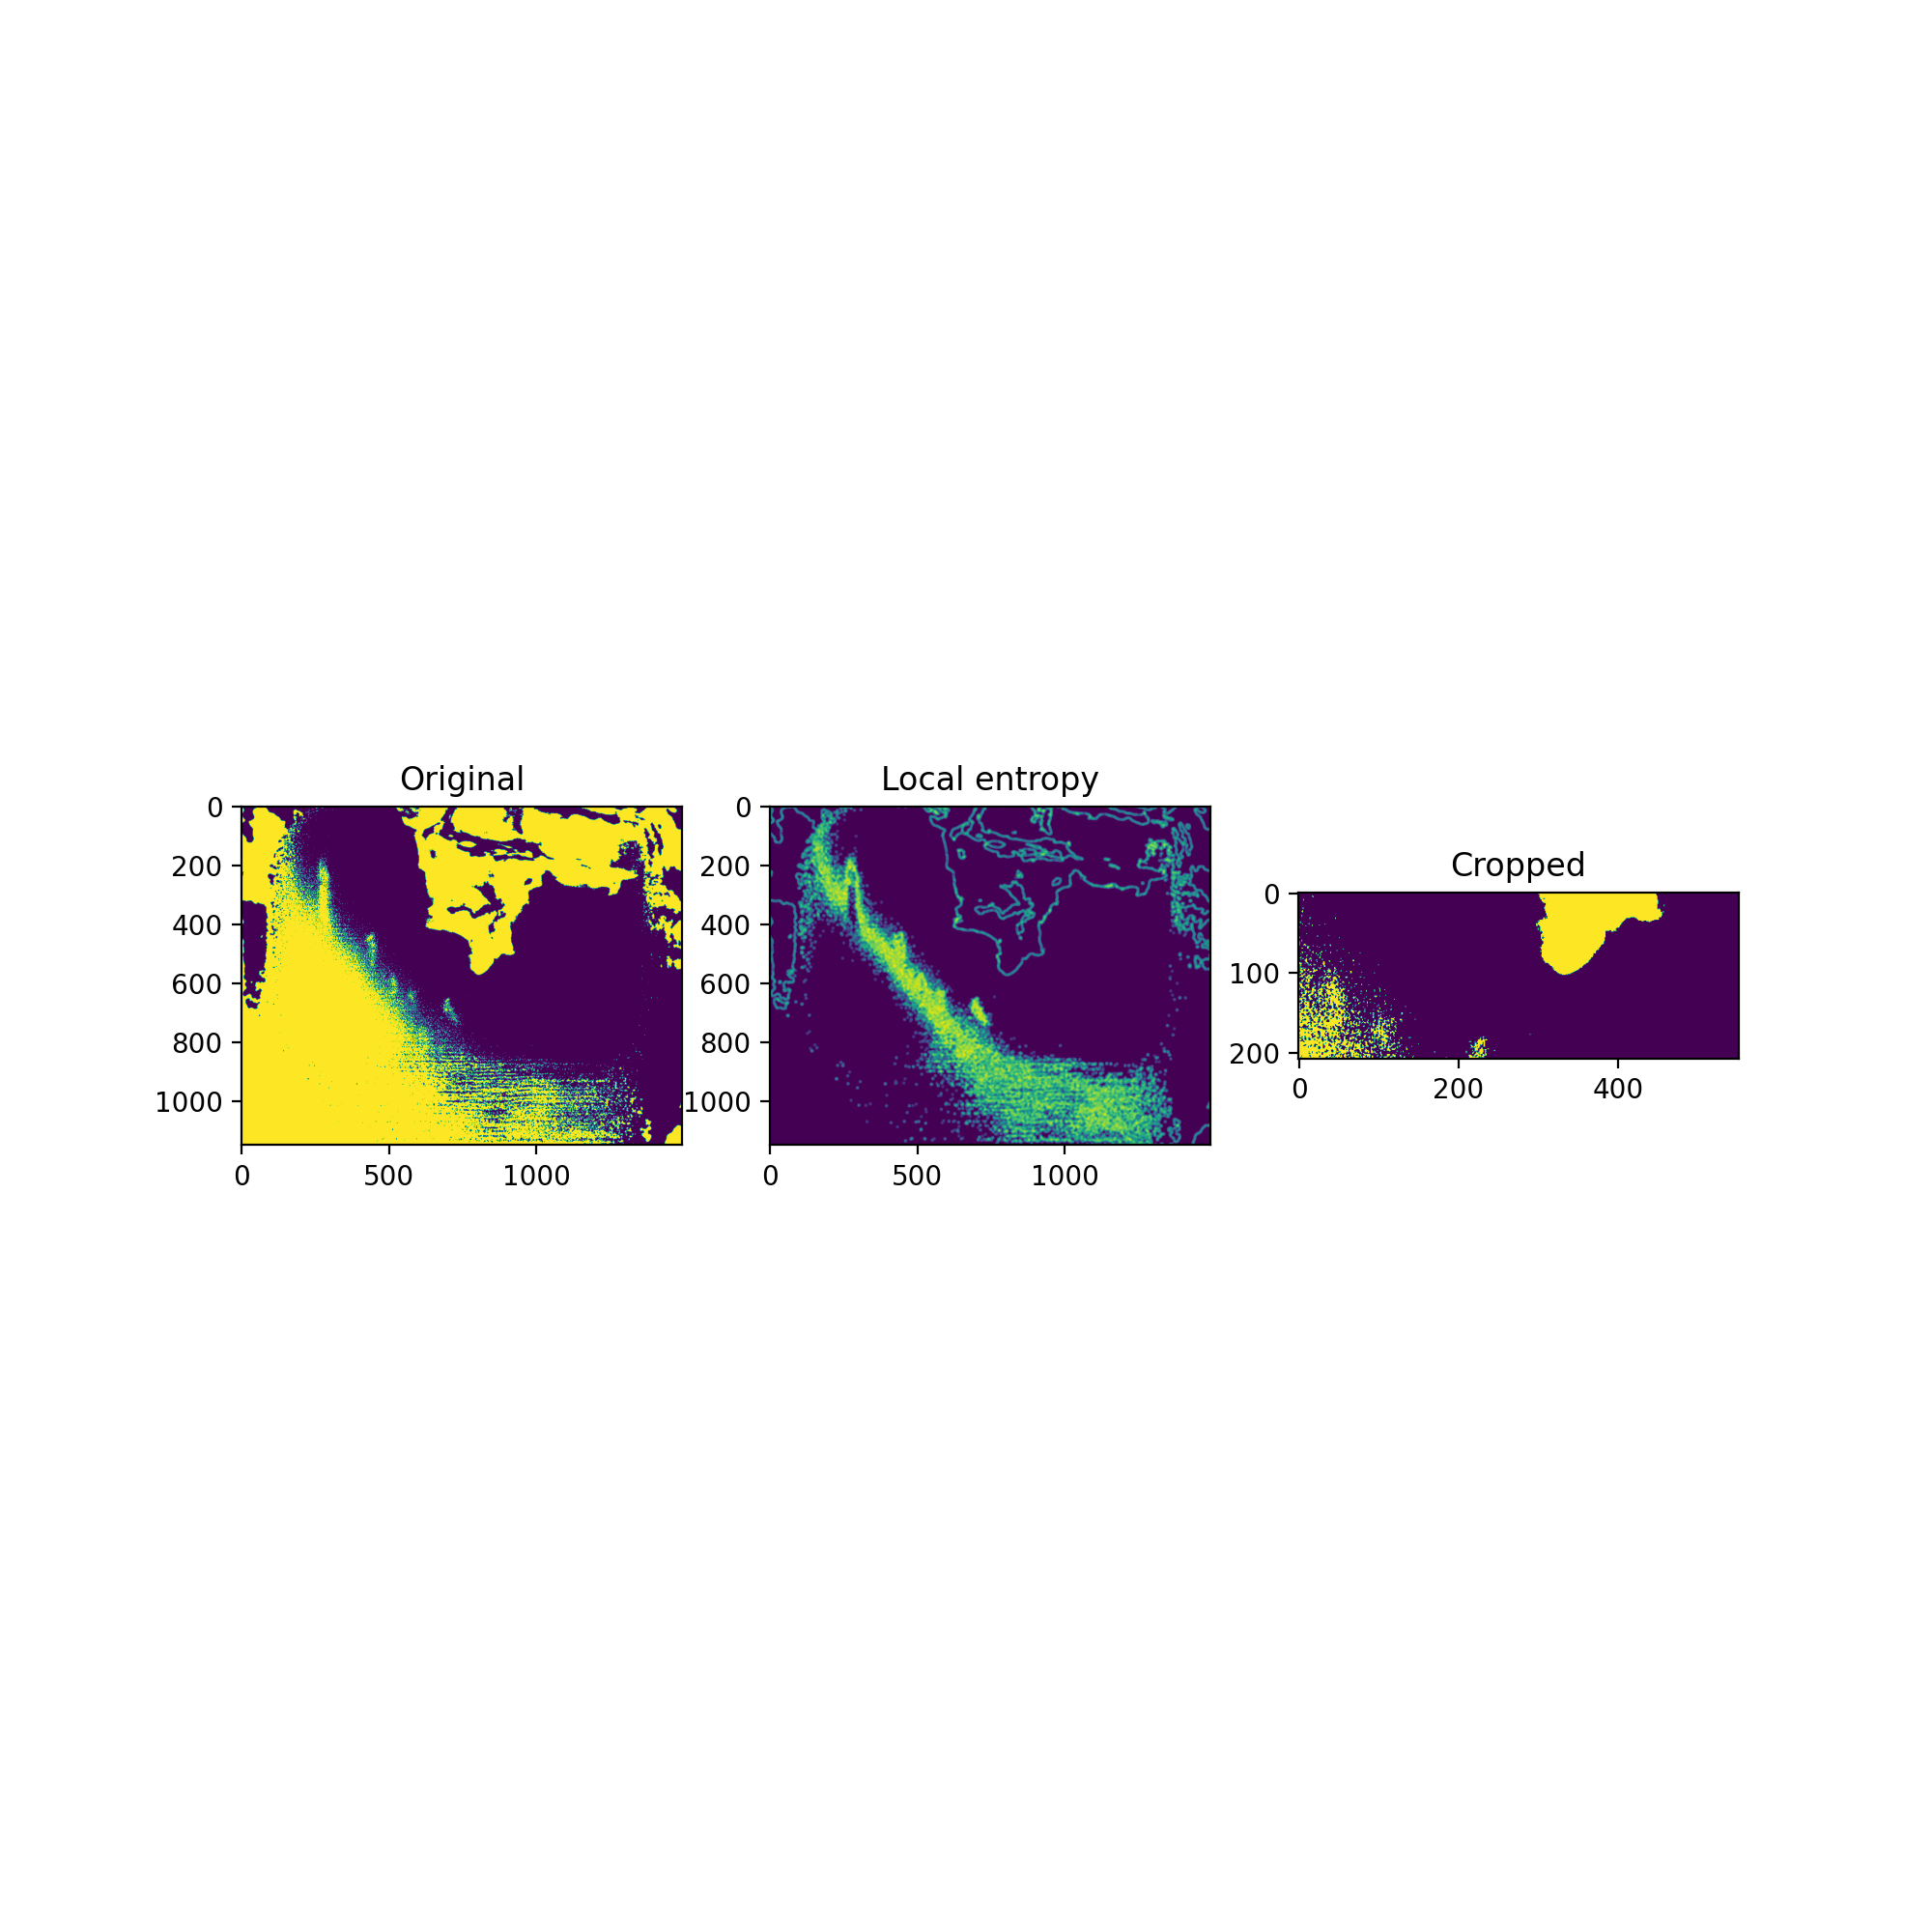

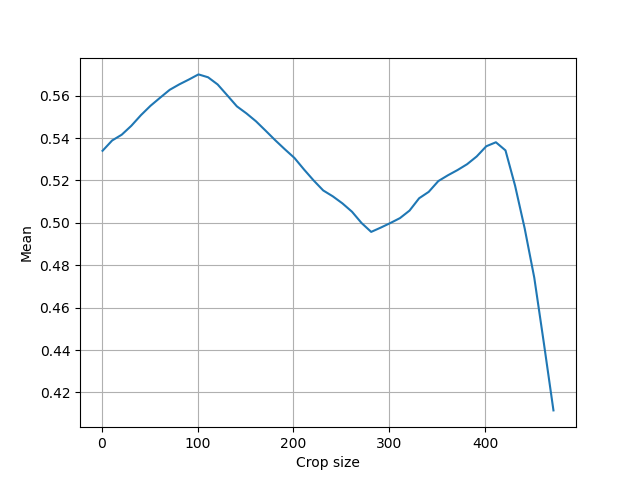

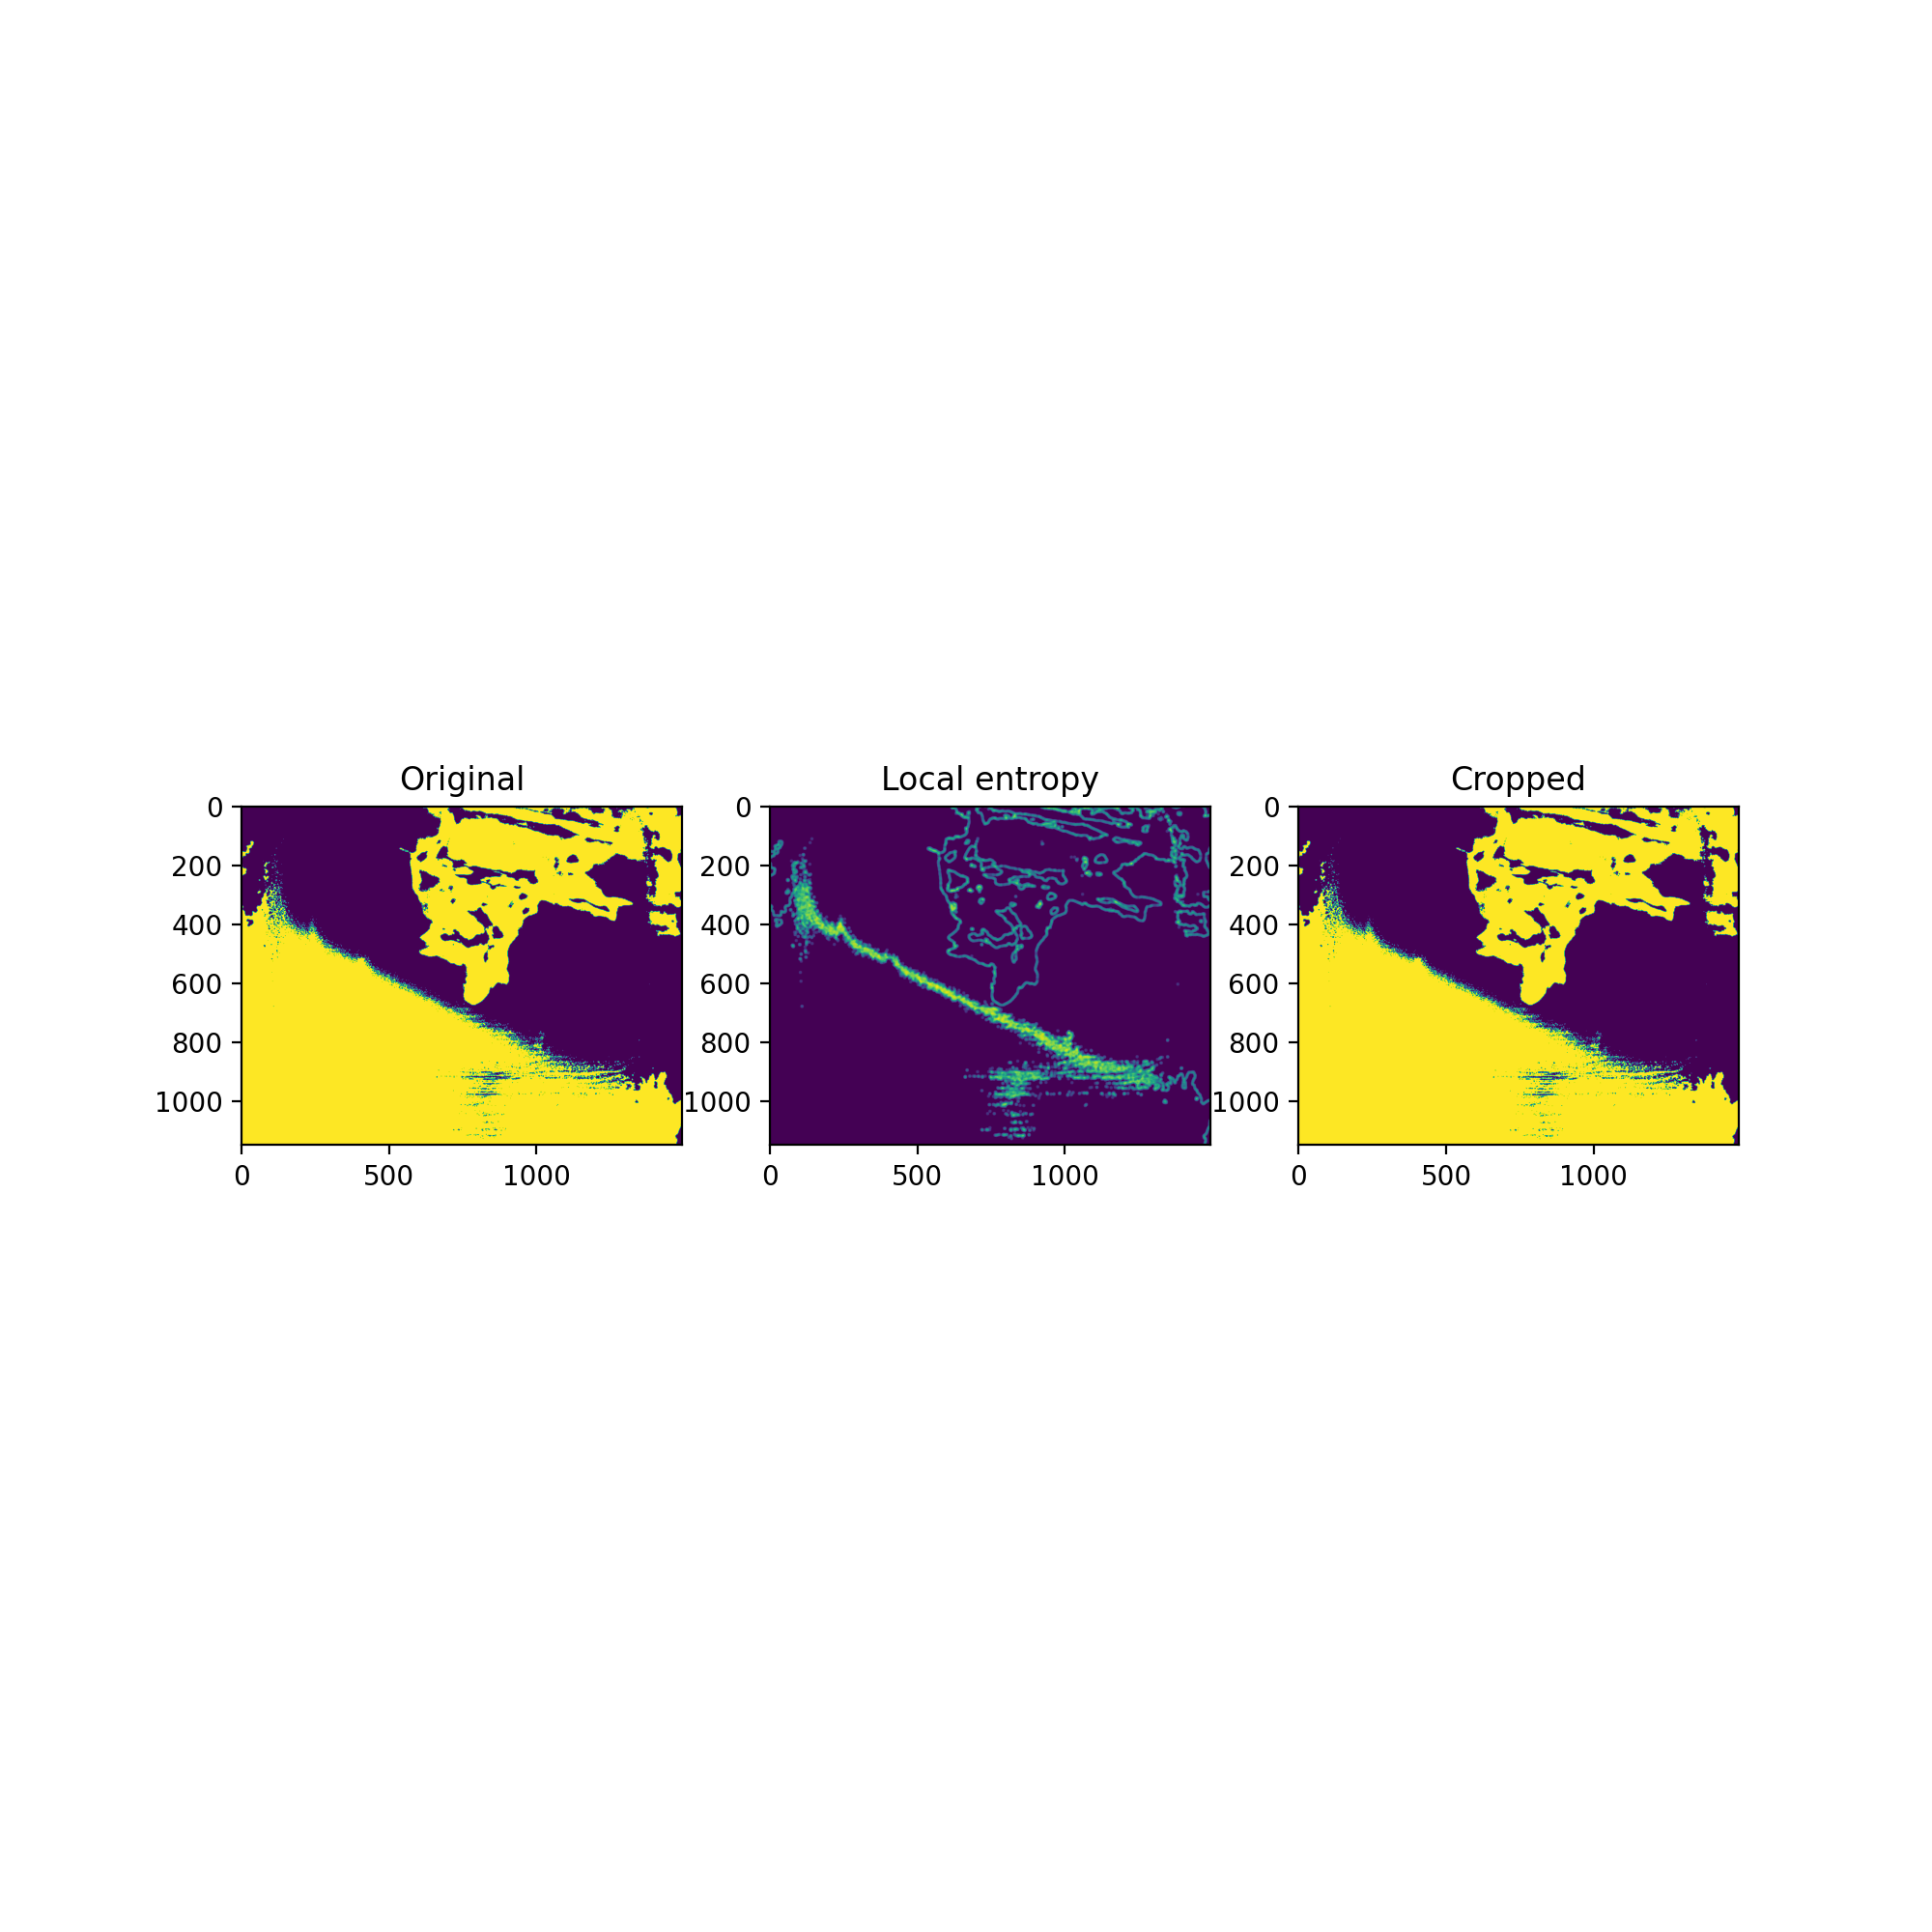

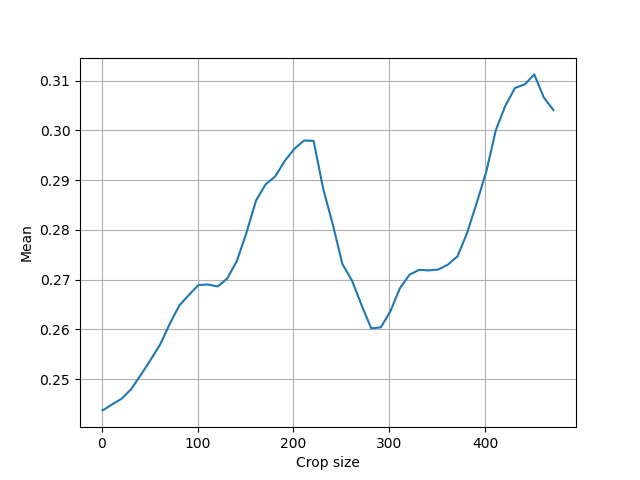

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def auto_crop_noise_borders(complex_array):
    """ Crop noisy borders of the reconstructed object using a local entropy map of the phase

    Args:
        complex_array : reconstructed object

    Returns:
        cropped_array : object without noisy borders
    """    
    import skimage.filters
    from skimage.morphology import disk

    img = np.angle(complex_array)  # get phase to perform cropping analysis

    img_gradient = skimage.filters.scharr(img)
    img_gradient = skimage.util.img_as_ubyte(img_gradient / img_gradient.max())
    local_entropy_map = skimage.filters.rank.entropy(img_gradient, disk(5)) # disk gives size of the region used to calculate local entropy

    smallest_img_dimension = 200
    max_crop = img.shape[0] // 2 - smallest_img_dimension // 2  # smallest image after cropping will have 2*100 pixels in each direction

    crop_sizes = range(1, max_crop, 10)

    mean_list = []
    for c in (crop_sizes):
        """
        mean is a good metric since we expect it to decrease as high entropy border
        gets cropped, and increase again as the low entropy smooth background gets cropped.
        it may become an issue if the sample is displaced from the center, though
        """
        mean = (local_entropy_map[c:-c, c:-c].ravel()).mean()
        mean_list.append(mean)

    best_crop = crop_sizes[np.where(mean_list == min(mean_list))[0][0]]

    cropped_array = complex_array[best_crop:-best_crop, best_crop:-best_crop]  # crop original complex image

    if 1:  # debug / see results
        figure, subplot = plt.subplots(1, 3, figsize=(10, 10), dpi=200)
        subplot[0].imshow(img)
        subplot[1].imshow(local_entropy_map)
        subplot[2].imshow(np.angle(cropped_array))
        subplot[0].set_title('Original')
        subplot[1].set_title('Local entropy')

        subplot[2].set_title('Cropped')

        figure, subplot = plt.subplots()
        subplot.plot(crop_sizes, mean_list)
        subplot.set_xlabel('Crop size')
        subplot.set_ylabel('Mean')
        subplot.grid()

    # if cropped_array.shape[0] % 2 != 0:  # object array must have even number of pixels to avoid bug during the phase unwrapping later on
    #     cropped_array = cropped_array[0:-1, :]
    # if cropped_array.shape[1] % 2 != 0:
    #     cropped_array = cropped_array[:, 0:-1]

    return best_crop

# sinogram = np.ones((15,100,100))
path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_cropped_sinogram.npy"
sinogram = np.load(path)

for frame in range(3):#sinogram.shape[0]):
    # print(frame)
    min_crop_value = []
    best_crop = auto_crop_noise_borders(sinogram[frame,:,:])
    min_crop_value.append(best_crop)
    print(best_crop)
min_crop = min(min_crop_value)

# cropped_sinogram = sinogram[:, min_crop:-min_crop-1, min_crop:-min_crop-1]

# if cropped_sinogram.shape[1] % 2 != 0:  # object array must have even number of pixels to avoid bug during the phase unwrapping later on
#     cropped_sinogram = cropped_sinogram[:,0:-1, :]
# if cropped_sinogram.shape[2] % 2 != 0:
#     cropped_sinogram = cropped_sinogram[:,:, 0:-1]